In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [9]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [10]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [11]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [12]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [13]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [14]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [15]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [16]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   action_names=env.feature_names,
                  
                  plot_qvalues = with_plots)

session # 0
 X1(qv = 0.0) -> 1.0 |  X1(qv = 0.119969323277) -> -0.5 |  X1(qv = 0.186319738626) -> -0.5 |  X1(qv = 0.221879005432) -> -0.5 |  X1(qv = 0.240459352732) -> -0.5 |  X1(qv = 0.249930113554) -> -0.5 |  X3(qv = 0.193606302142) -> -1.0 |  X3(qv = 0.0687453746796) -> -0.5 |  Y2(qv = -0.10860915482) -> 3.0 |  X1(qv = 0.108330197632) -> -0.5 | reached max session length


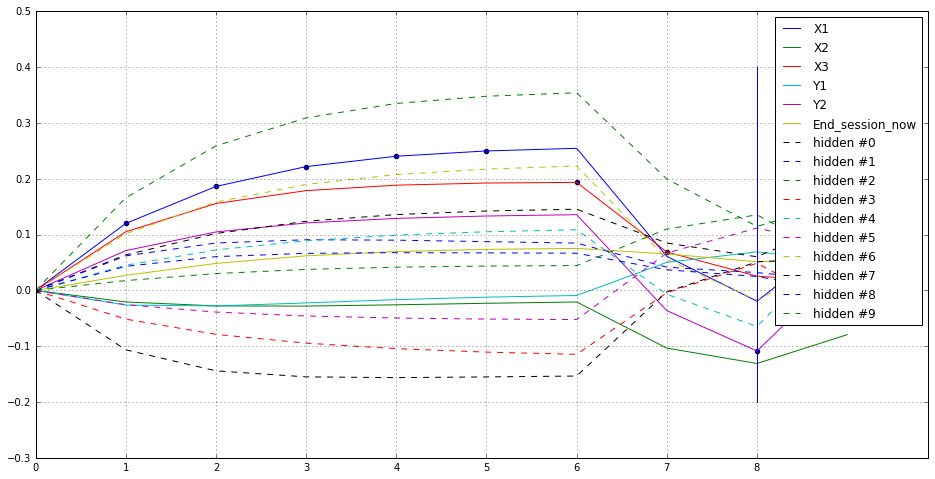

In [17]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [18]:
from agentnet.display import Metrics
score_log = Metrics()

In [19]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 9.18887, epsilon 0.96275, rewards: ( e-greedy -0.11500, greedy -0.33000) 
rec 9.175 reg 0.014
epoch 200,loss 13.10491, epsilon 0.92696, rewards: ( e-greedy -0.15350, greedy -0.62700) 
rec 13.091 reg 0.014
epoch 300,loss 8.77393, epsilon 0.89257, rewards: ( e-greedy -0.18315, greedy -0.77430) 
rec 8.760 reg 0.014
epoch 400,loss 13.94729, epsilon 0.85954, rewards: ( e-greedy -0.25983, greedy -0.96687) 
rec 13.933 reg 0.014
epoch 500,loss 7.50784, epsilon 0.82779, rewards: ( e-greedy -0.28885, greedy -1.21518) 
rec 7.494 reg 0.014
epoch 600,loss 11.60554, epsilon 0.79730, rewards: ( e-greedy -0.31997, greedy -1.53366) 
rec 11.591 reg 0.015
epoch 700,loss 10.86329, epsilon 0.76799, rewards: ( e-greedy -0.39297, greedy -1.19030) 
rec 10.848 reg 0.016
epoch 800,loss 10.13658, epsilon 0.73984, rewards: ( e-greedy -0.31867, greedy -0.94127) 
rec 10.120 reg 0.017
epoch 900,loss 8.34380, epsilon 0.71279, rewards: ( e-greedy -0.34181, greedy -0.80714) 
rec 8.326 reg 0.018
epoch 100

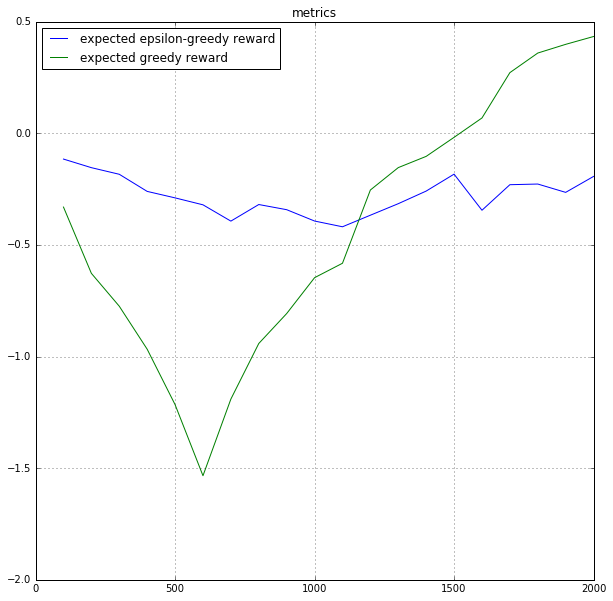

Random session examples
session # 0
 Y2(qv = 1.26521742344) -> 3.0 |  X2(qv = 0.115441054106) -> -1.0 |  End_session_now(qv = 0.0250736512244) -> 0.0 | 



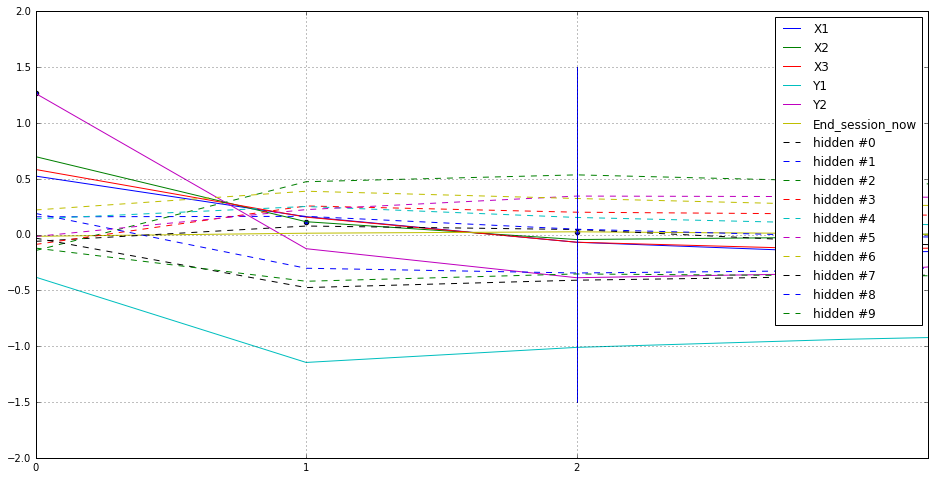

session # 1
 X1(qv = 0.524307131767) -> 1.0 |  X2(qv = 0.715828418732) -> -1.0 |  Y2(qv = 1.11062717438) -> 3.0 |  End_session_now(qv = 0.00163208320737) -> 0.0 | 



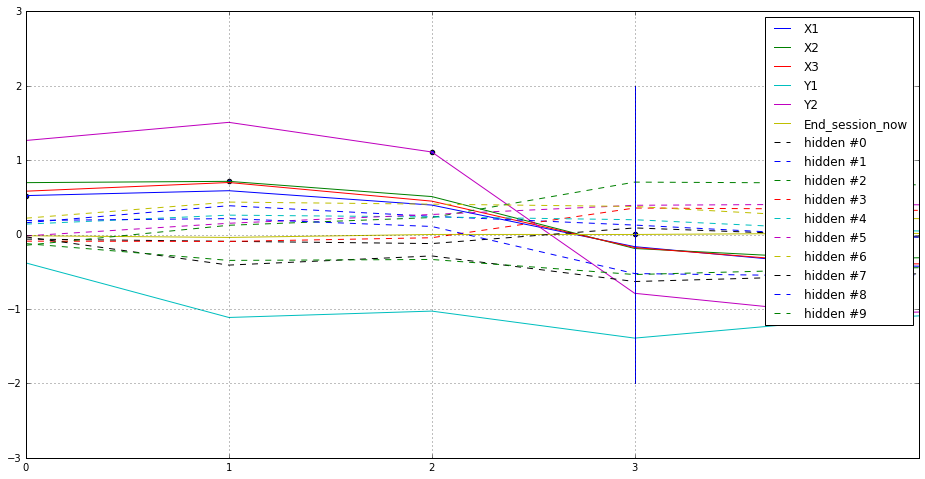

session # 2
 X3(qv = 0.583482205868) -> 1.0 |  X2(qv = 0.667890071869) -> -1.0 |  Y2(qv = 1.38120138645) -> 3.0 |  End_session_now(qv = 0.00503859296441) -> 0.0 | 



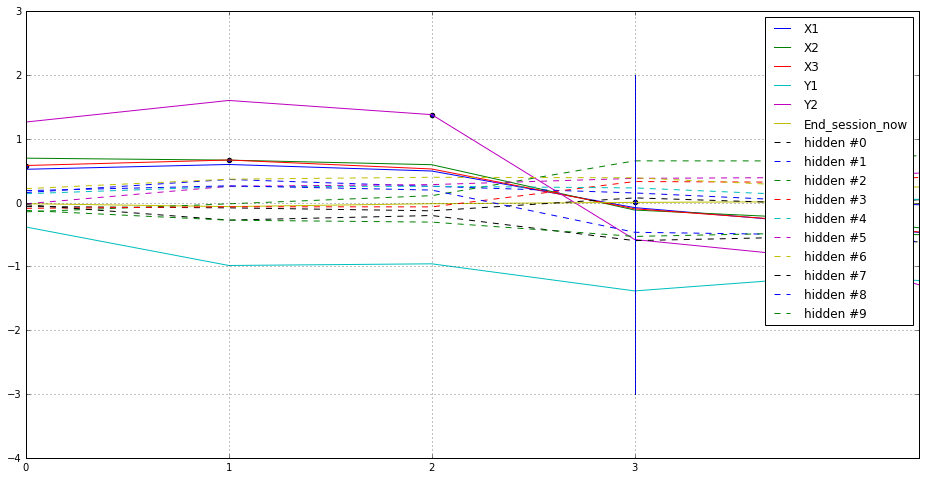

epoch 2100,loss 10.69054, epsilon 0.46012, rewards: ( e-greedy 0.03151, greedy 0.62069) 
rec 10.663 reg 0.028
epoch 2200,loss 13.01127, epsilon 0.44404, rewards: ( e-greedy 0.05336, greedy 0.67862) 
rec 12.983 reg 0.028
epoch 2300,loss 5.37746, epsilon 0.42859, rewards: ( e-greedy 0.21802, greedy 0.80076) 
rec 5.349 reg 0.029
epoch 2400,loss 10.23196, epsilon 0.41375, rewards: ( e-greedy 0.29622, greedy 0.91068) 
rec 10.203 reg 0.029
epoch 2500,loss 8.37612, epsilon 0.39949, rewards: ( e-greedy 0.23160, greedy 0.94961) 
rec 8.347 reg 0.030
epoch 2600,loss 6.64391, epsilon 0.38578, rewards: ( e-greedy 0.22844, greedy 0.98465) 
rec 6.614 reg 0.030
epoch 2700,loss 10.93723, epsilon 0.37262, rewards: ( e-greedy 0.34559, greedy 1.05619) 
rec 10.907 reg 0.030
epoch 2800,loss 5.64747, epsilon 0.35997, rewards: ( e-greedy 0.40103, greedy 1.24057) 
rec 5.617 reg 0.031
epoch 2900,loss 5.14973, epsilon 0.34781, rewards: ( e-greedy 0.45093, greedy 1.36651) 
rec 5.119 reg 0.031
epoch 3000,loss 5.62

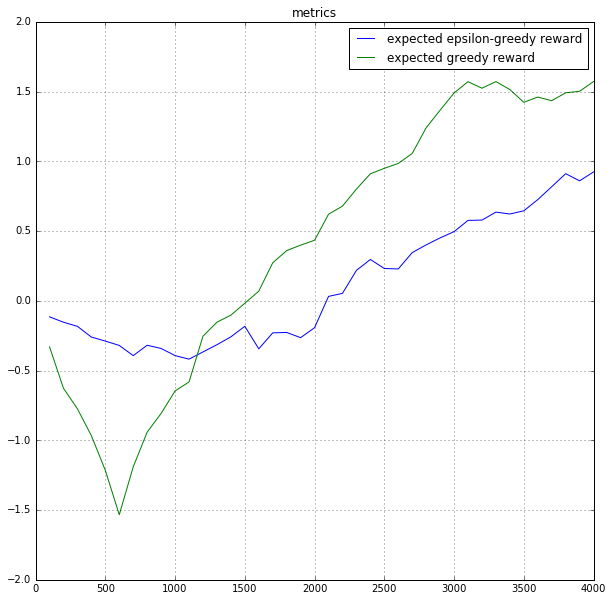

Random session examples
session # 0
 Y2(qv = 1.84368944168) -> 3.0 |  X1(qv = 0.290346682072) -> 1.0 |  End_session_now(qv = -0.00580842234194) -> 0.0 | 



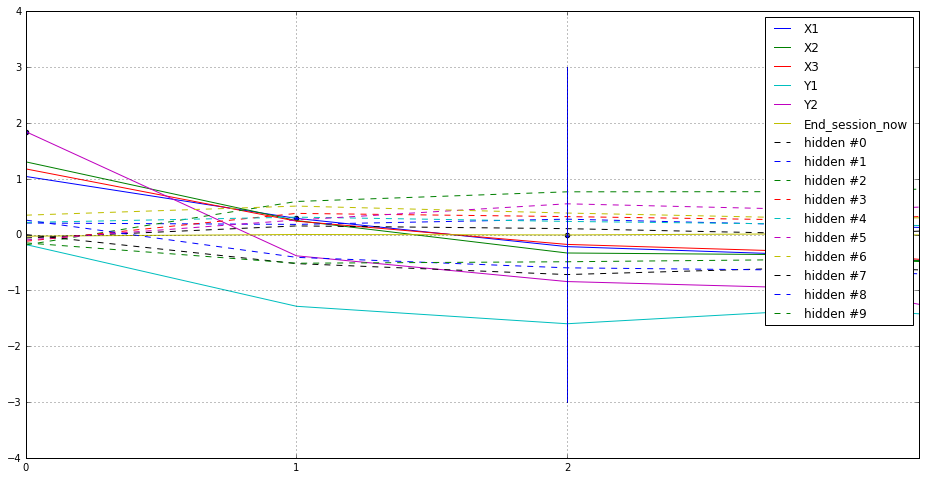

session # 1
 X1(qv = 1.04150867462) -> 1.0 |  Y2(qv = 1.60587203503) -> 3.0 |  End_session_now(qv = -0.00755773670971) -> 0.0 | 



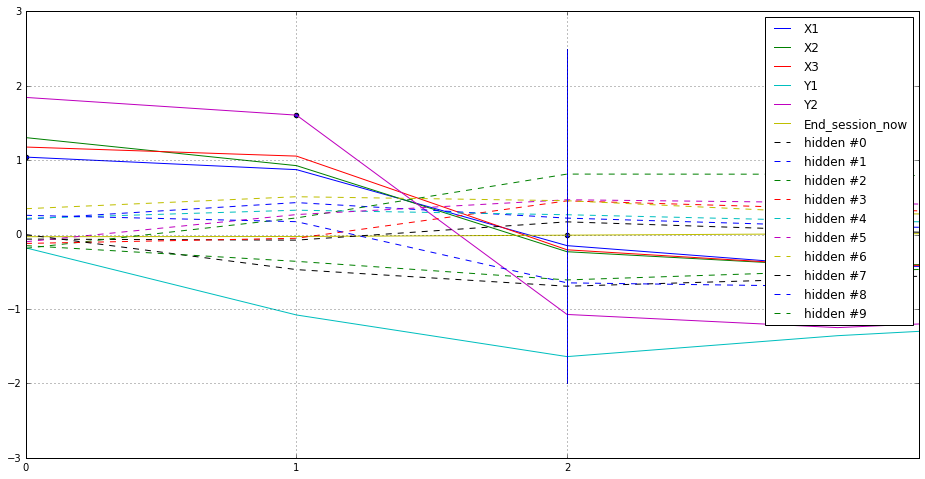

session # 2
 Y2(qv = 1.84368932247) -> 3.0 |  X1(qv = 0.290346682072) -> -1.0 |  End_session_now(qv = 0.0124733131379) -> 0.0 | 



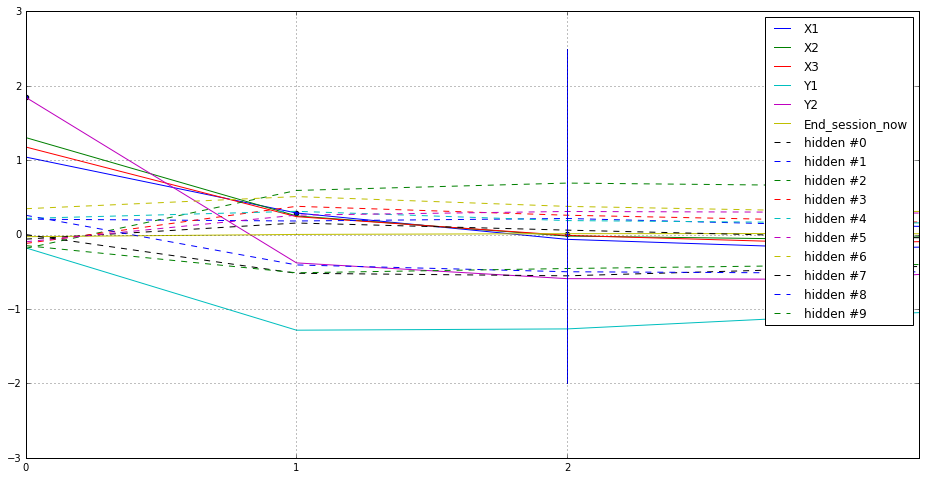

epoch 4100,loss 7.81839, epsilon 0.23428, rewards: ( e-greedy 0.88162, greedy 1.55458) 
rec 7.784 reg 0.034
epoch 4200,loss 5.92225, epsilon 0.22706, rewards: ( e-greedy 0.98345, greedy 1.61912) 
rec 5.888 reg 0.035
epoch 4300,loss 8.53943, epsilon 0.22011, rewards: ( e-greedy 0.91011, greedy 1.51721) 
rec 8.505 reg 0.035
epoch 4400,loss 8.08399, epsilon 0.21344, rewards: ( e-greedy 0.90910, greedy 1.48549) 
rec 8.049 reg 0.035
epoch 4500,loss 5.37285, epsilon 0.20703, rewards: ( e-greedy 0.98319, greedy 1.57694) 
rec 5.338 reg 0.035
epoch 4600,loss 3.55143, epsilon 0.20088, rewards: ( e-greedy 1.11987, greedy 1.71924) 
rec 3.516 reg 0.035
epoch 4700,loss 7.97295, epsilon 0.19496, rewards: ( e-greedy 1.09788, greedy 1.66732) 
rec 7.937 reg 0.036
epoch 4800,loss 11.75812, epsilon 0.18928, rewards: ( e-greedy 0.96809, greedy 1.54059) 
rec 11.722 reg 0.036
epoch 4900,loss 5.31944, epsilon 0.18382, rewards: ( e-greedy 0.98128, greedy 1.60653) 
rec 5.284 reg 0.036
epoch 5000,loss 7.01958, e

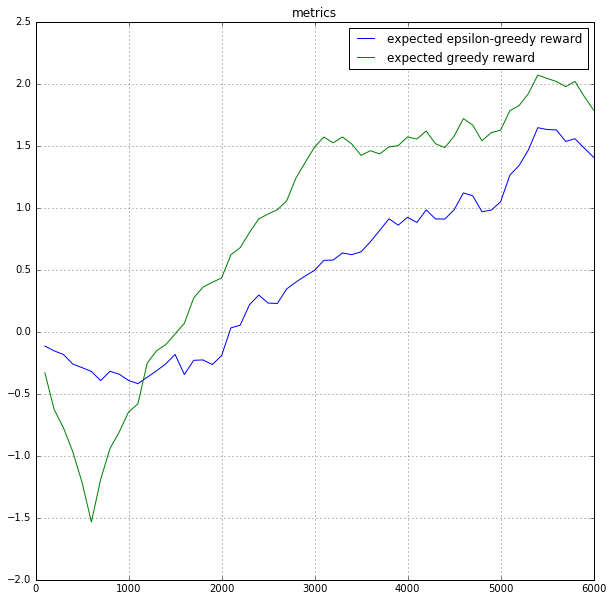

Random session examples
session # 0
 Y2(qv = 1.97387981415) -> -3.0 |  X2(qv = 0.991445124149) -> 1.0 |  End_session_now(qv = 0.000133365392685) -> 0.0 | 



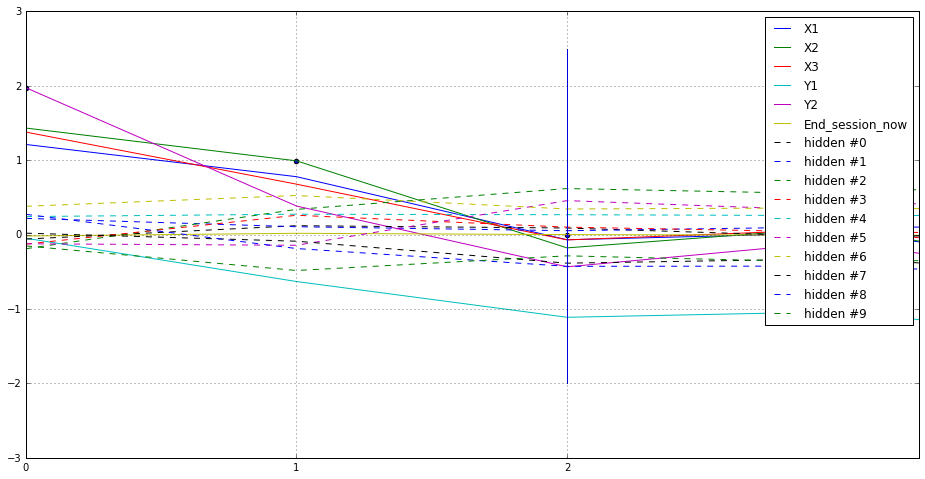

session # 1
 Y2(qv = 1.97387981415) -> -3.0 |  X2(qv = 0.991445124149) -> 1.0 |  End_session_now(qv = 0.000133365392685) -> 0.0 | 



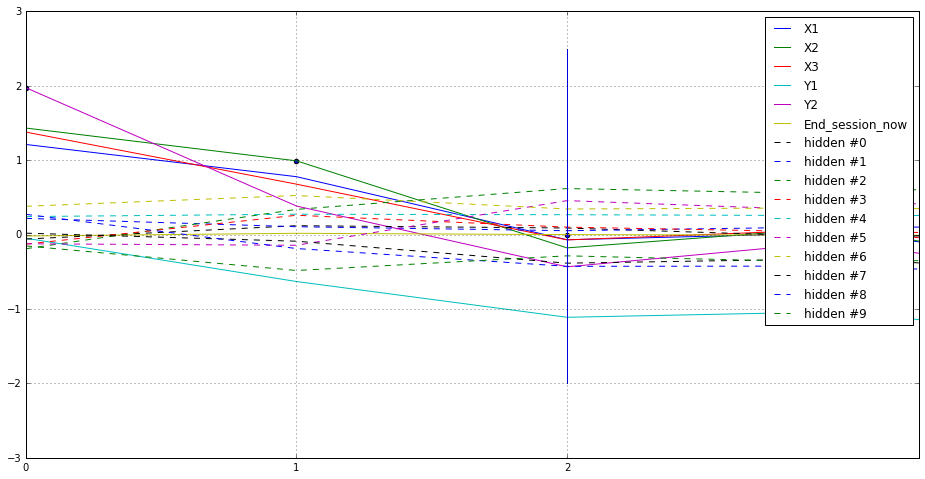

session # 2
 X2(qv = 1.4319871664) -> -1.0 |  Y2(qv = 2.25922012329) -> 3.0 |  X1(qv = 0.31726667285) -> -1.0 |  X1(qv = -0.0643892884254) -> -0.5 |  End_session_now(qv = -0.00961972028017) -> 0.0 | 



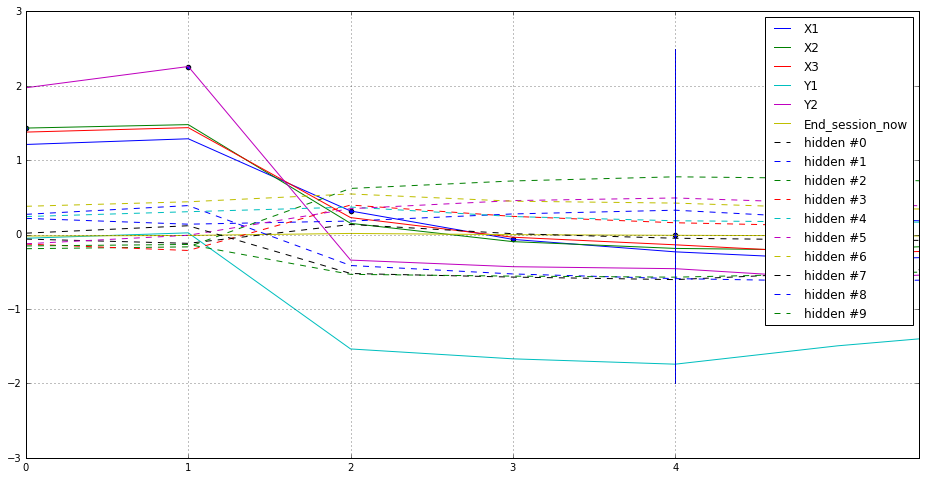

epoch 6100,loss 8.36760, epsilon 0.13280, rewards: ( e-greedy 1.43729, greedy 1.78886) 
rec 8.330 reg 0.037
epoch 6200,loss 6.71934, epsilon 0.12956, rewards: ( e-greedy 1.45356, greedy 1.80998) 
rec 6.682 reg 0.037
epoch 6300,loss 3.93703, epsilon 0.12644, rewards: ( e-greedy 1.56820, greedy 1.92898) 
rec 3.900 reg 0.037
epoch 6400,loss 5.17723, epsilon 0.12344, rewards: ( e-greedy 1.66138, greedy 2.01608) 
rec 5.140 reg 0.037
epoch 6500,loss 8.11891, epsilon 0.12056, rewards: ( e-greedy 1.60024, greedy 1.93447) 
rec 8.082 reg 0.037
epoch 6600,loss 8.01011, epsilon 0.11779, rewards: ( e-greedy 1.57022, greedy 1.88103) 
rec 7.973 reg 0.037
epoch 6700,loss 4.03706, epsilon 0.11513, rewards: ( e-greedy 1.64820, greedy 1.97292) 
rec 4.000 reg 0.038
epoch 6800,loss 6.70065, epsilon 0.11258, rewards: ( e-greedy 1.62838, greedy 1.95563) 
rec 6.663 reg 0.038
epoch 6900,loss 9.52747, epsilon 0.11013, rewards: ( e-greedy 1.60054, greedy 1.88007) 
rec 9.490 reg 0.038
epoch 7000,loss 7.19305, eps

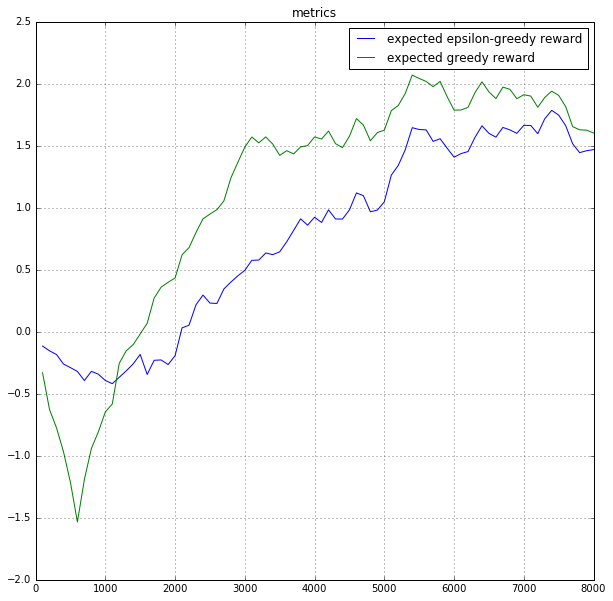

Random session examples
session # 0
 Y1(qv = 0.0280620753765) -> 3.0 |  Y2(qv = 1.14095282555) -> -3.0 |  X2(qv = 0.338272511959) -> 1.0 |  End_session_now(qv = -0.000867849215865) -> 0.0 | 



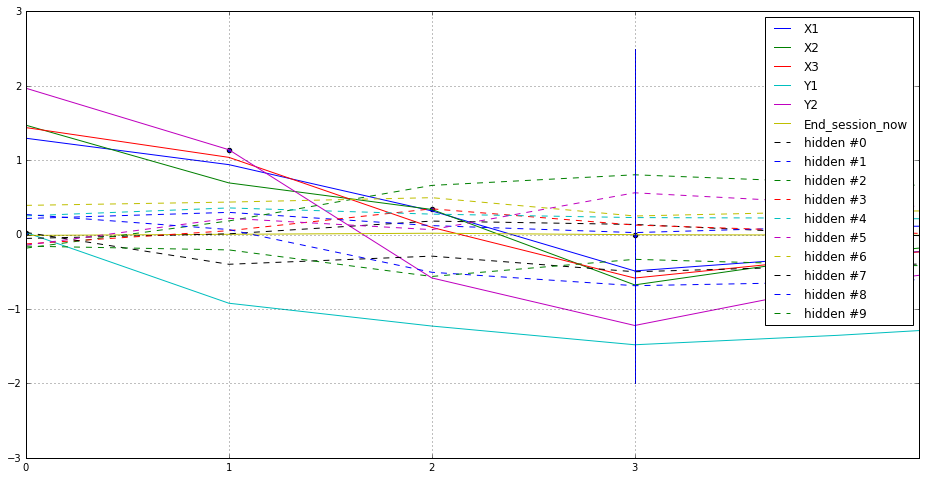

session # 1
 Y2(qv = 1.96726155281) -> -3.0 |  X2(qv = 1.00836575031) -> 1.0 |  End_session_now(qv = 0.00052179209888) -> 0.0 | 



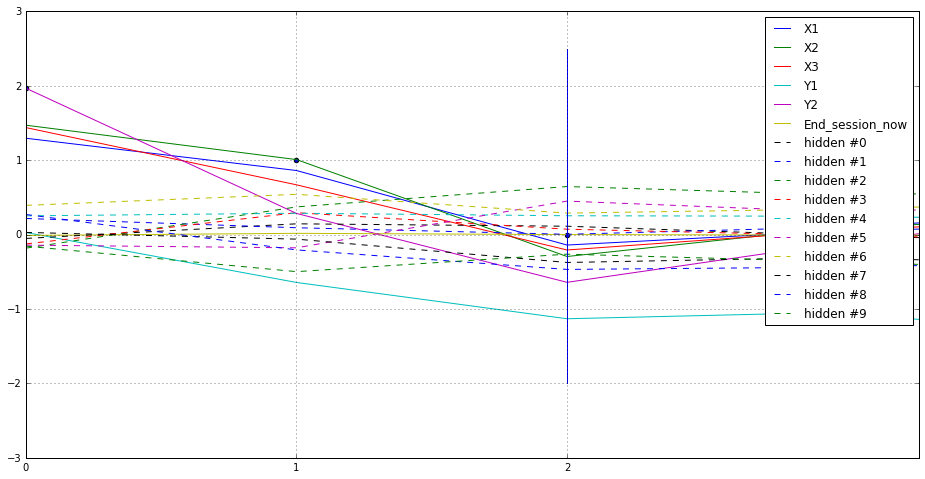

session # 2
 Y2(qv = 1.96726131439) -> 3.0 |  X1(qv = 0.335734248161) -> 1.0 |  End_session_now(qv = 0.000624539330602) -> 0.0 | 



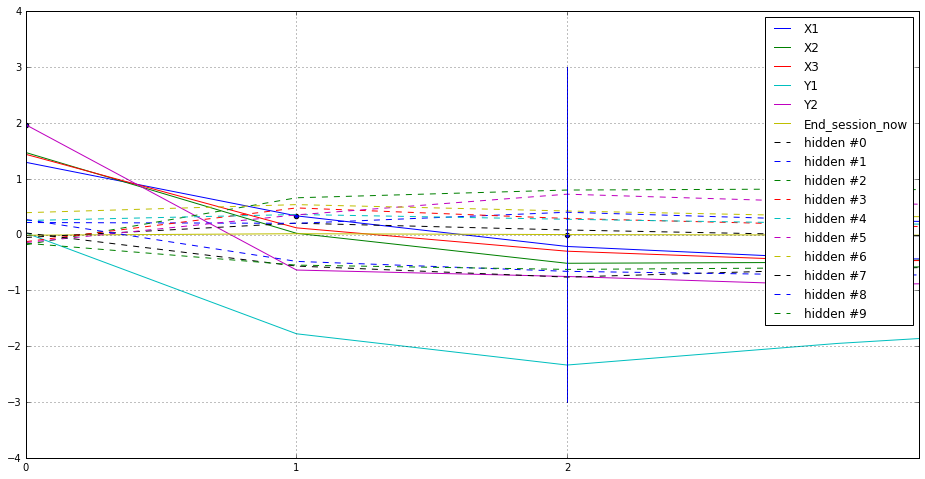

epoch 8100,loss 5.66915, epsilon 0.08721, rewards: ( e-greedy 1.46733, greedy 1.64310) 
rec 5.631 reg 0.038
epoch 8200,loss 9.54300, epsilon 0.08575, rewards: ( e-greedy 1.41060, greedy 1.55879) 
rec 9.505 reg 0.038
epoch 8300,loss 8.48524, epsilon 0.08435, rewards: ( e-greedy 1.46454, greedy 1.58291) 
rec 8.448 reg 0.038
epoch 8400,loss 8.16409, epsilon 0.08300, rewards: ( e-greedy 1.41808, greedy 1.52462) 
rec 8.127 reg 0.038
epoch 8500,loss 5.67458, epsilon 0.08170, rewards: ( e-greedy 1.47628, greedy 1.57216) 
rec 5.637 reg 0.038
epoch 8600,loss 3.99180, epsilon 0.08046, rewards: ( e-greedy 1.62865, greedy 1.71494) 
rec 3.954 reg 0.038
epoch 8700,loss 9.54299, epsilon 0.07927, rewards: ( e-greedy 1.63578, greedy 1.70345) 
rec 9.505 reg 0.038
epoch 8800,loss 3.96660, epsilon 0.07812, rewards: ( e-greedy 1.69221, greedy 1.77310) 
rec 3.929 reg 0.038
epoch 8900,loss 6.53607, epsilon 0.07702, rewards: ( e-greedy 1.66298, greedy 1.77579) 
rec 6.499 reg 0.037
epoch 9000,loss 4.95797, eps

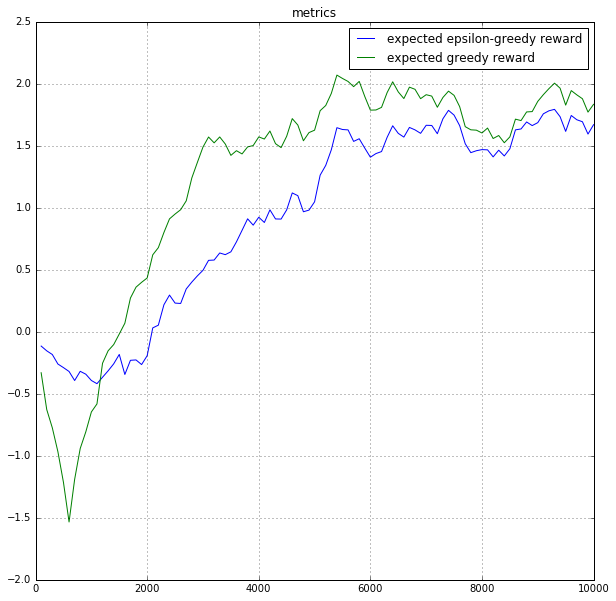

Random session examples
session # 0
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065855265) -> 1.0 |  End_session_now(qv = -3.77180986106e-05) -> 0.0 | 



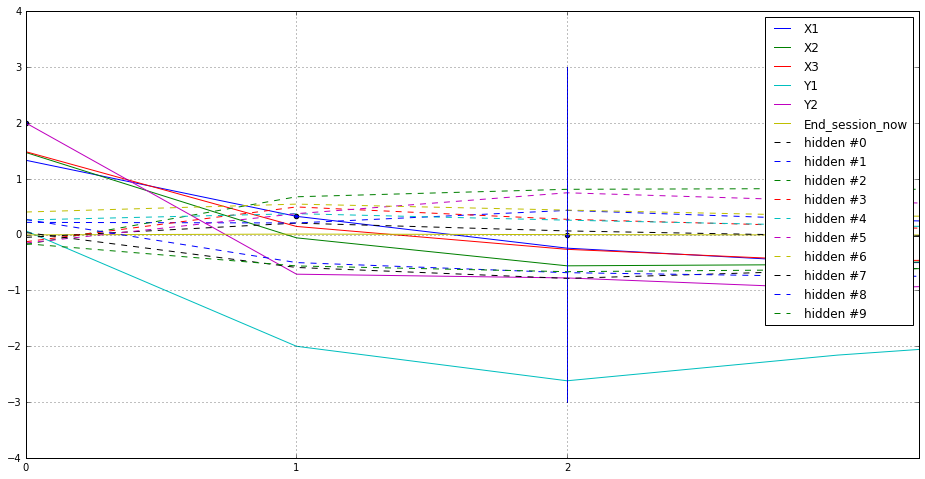

session # 1
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396385193) -> 1.0 |  End_session_now(qv = -0.000193800311536) -> 0.0 | 



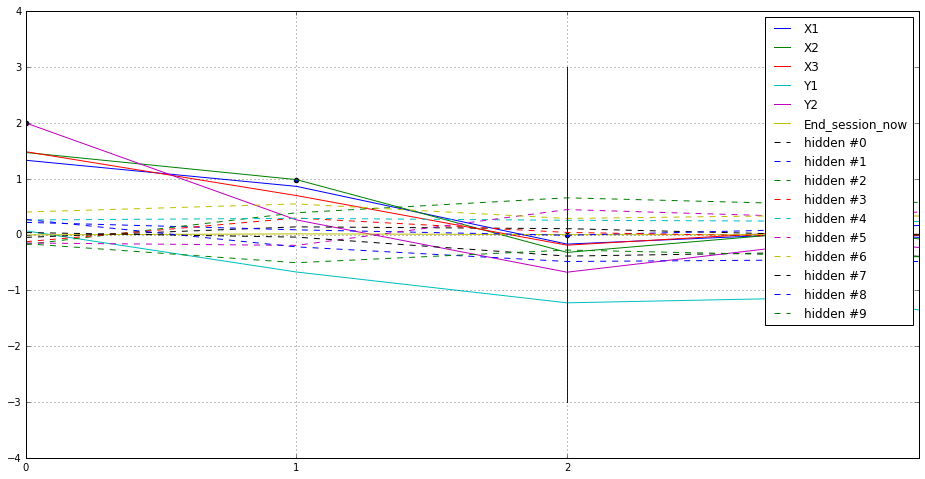

session # 2
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065855265) -> -1.0 |  End_session_now(qv = -0.00109968101606) -> 0.0 | 



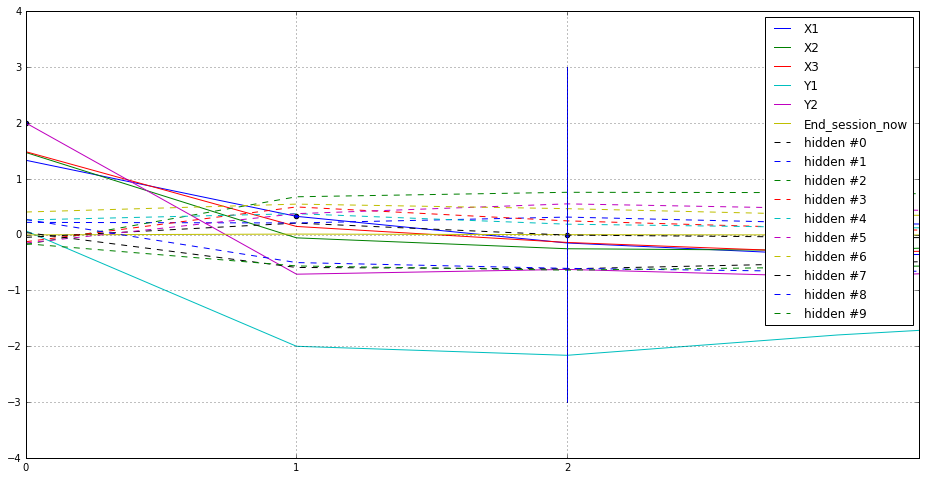

In [20]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

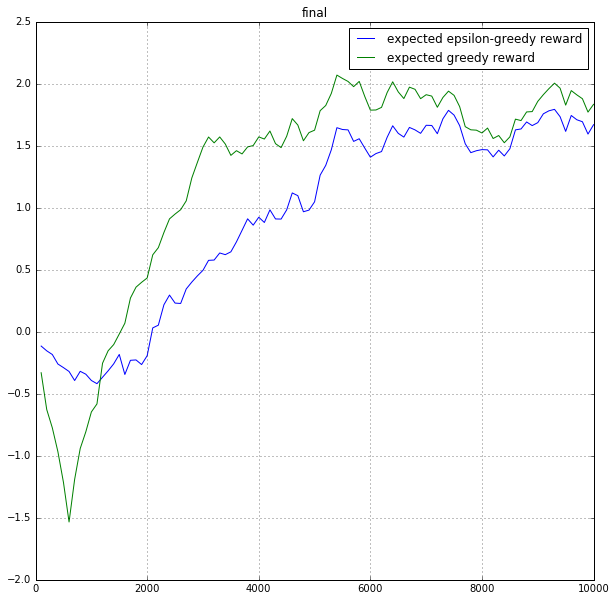

In [21]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396325588) -> 1.0 |  End_session_now(qv = -0.000193800311536) -> 0.0 | 



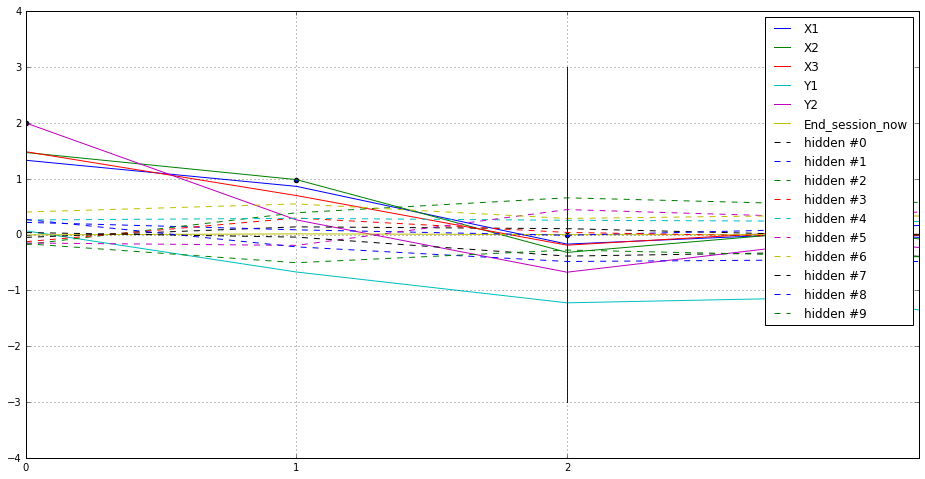

session # 1
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065825462) -> -1.0 |  End_session_now(qv = -0.00109968660399) -> 0.0 | 



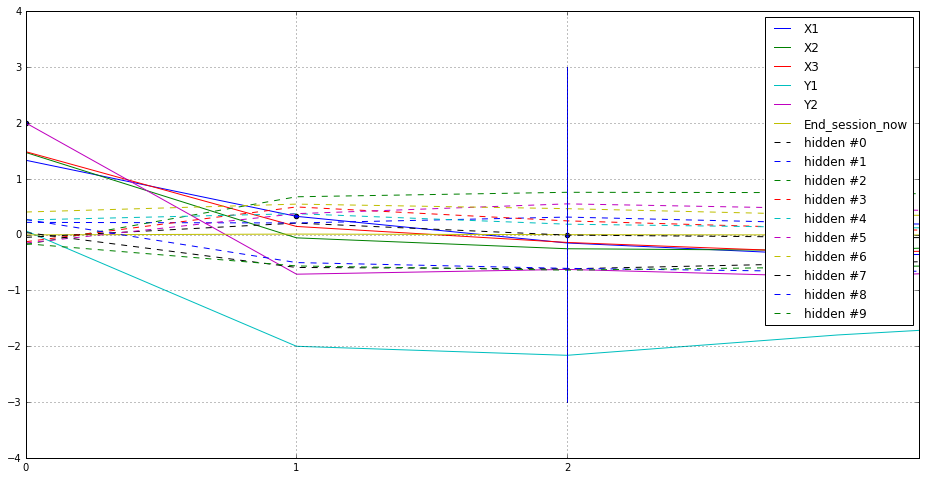

session # 2
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396325588) -> 1.0 |  End_session_now(qv = -0.000193800311536) -> 0.0 | 



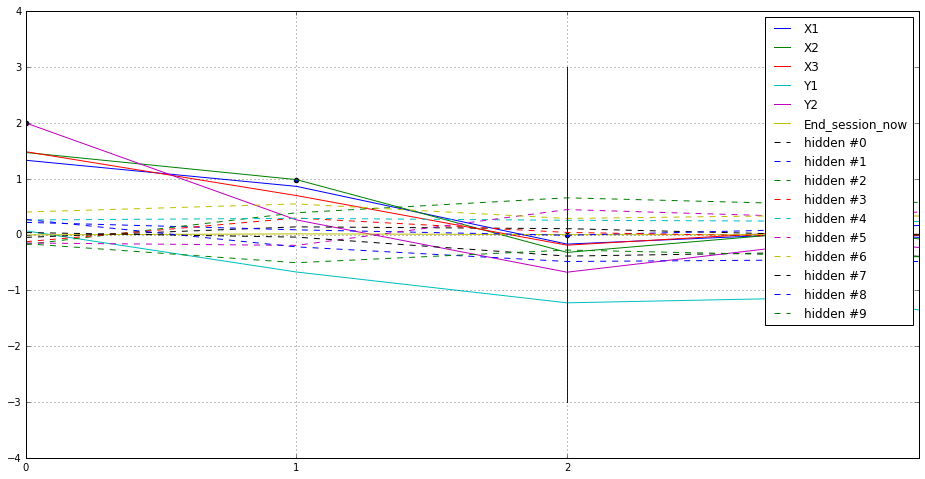

session # 3
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065825462) -> -1.0 |  End_session_now(qv = -0.00109968660399) -> 0.0 | 



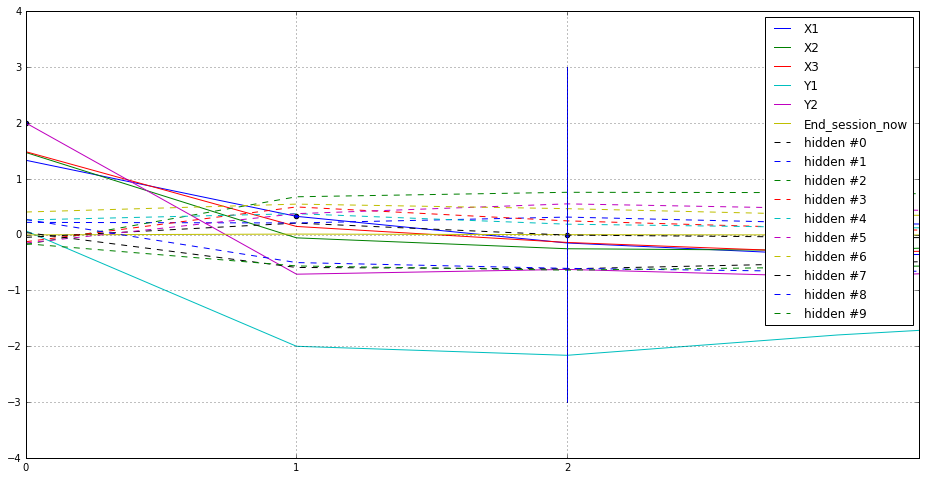

session # 4
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396385193) -> 1.0 |  End_session_now(qv = -0.000193806830794) -> 0.0 | 



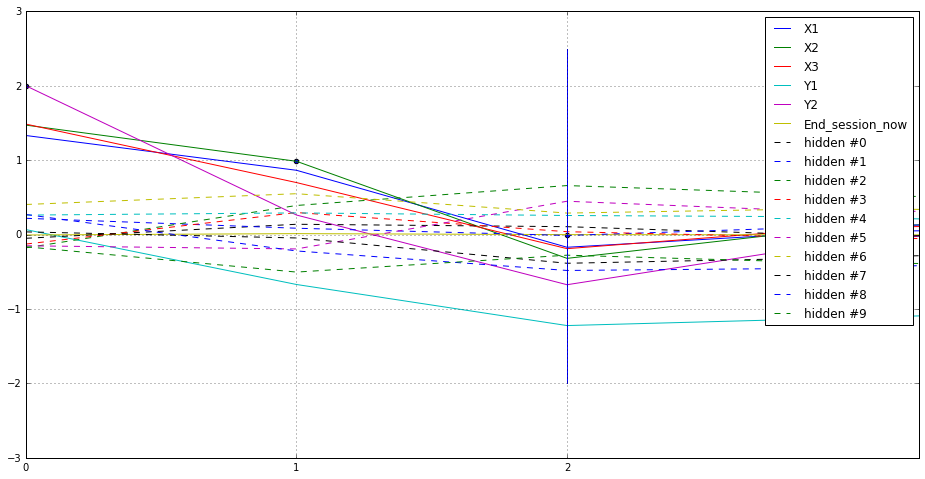

session # 5
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065825462) -> -1.0 |  End_session_now(qv = -0.00109968660399) -> 0.0 | 



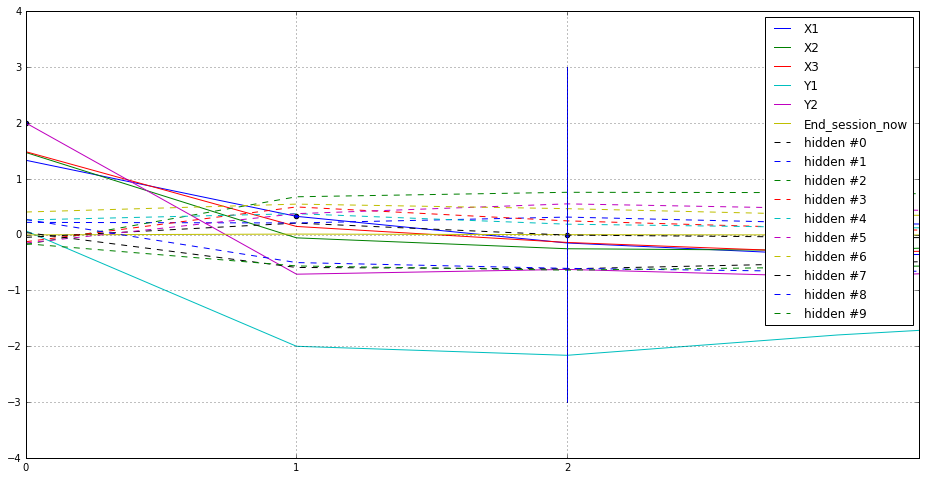

session # 6
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396325588) -> 1.0 |  End_session_now(qv = -0.000193800311536) -> 0.0 | 



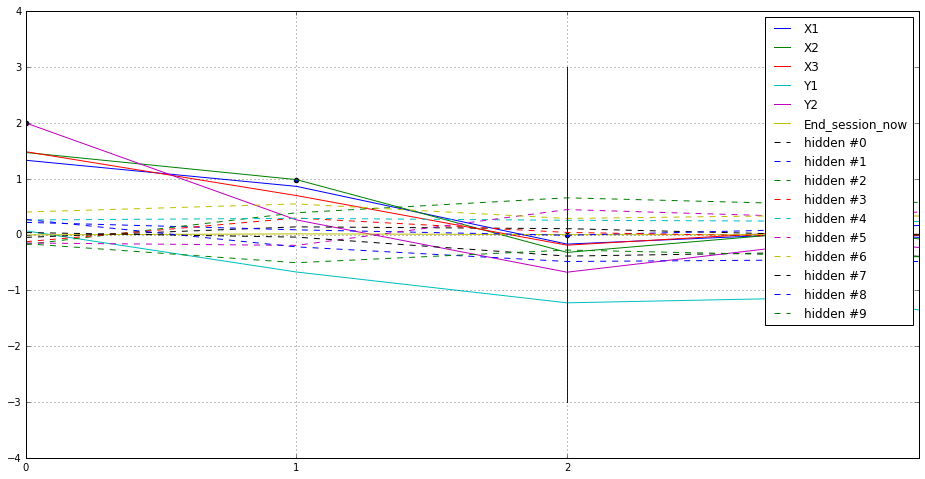

session # 7
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065825462) -> 1.0 |  End_session_now(qv = -3.77255491912e-05) -> 0.0 | 



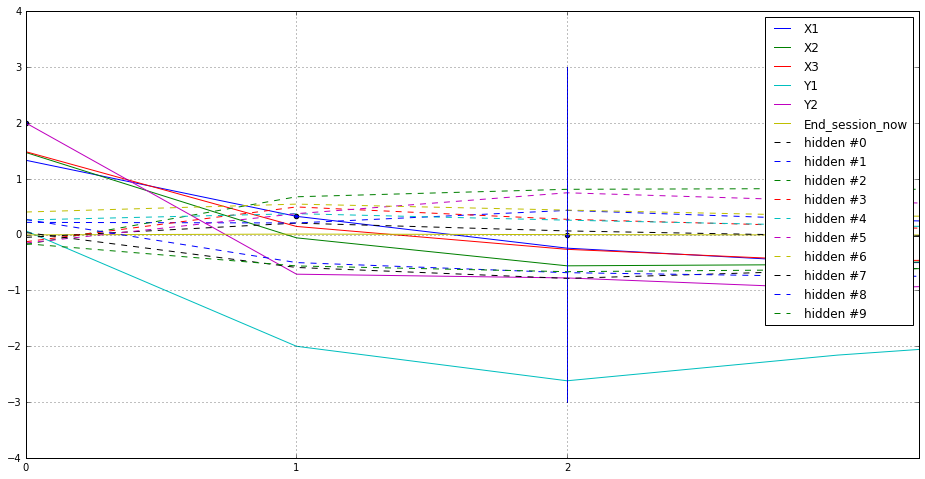

session # 8
 Y2(qv = 1.99966430664) -> 3.0 |  X1(qv = 0.327065825462) -> 1.0 |  End_session_now(qv = -3.77255491912e-05) -> 0.0 | 



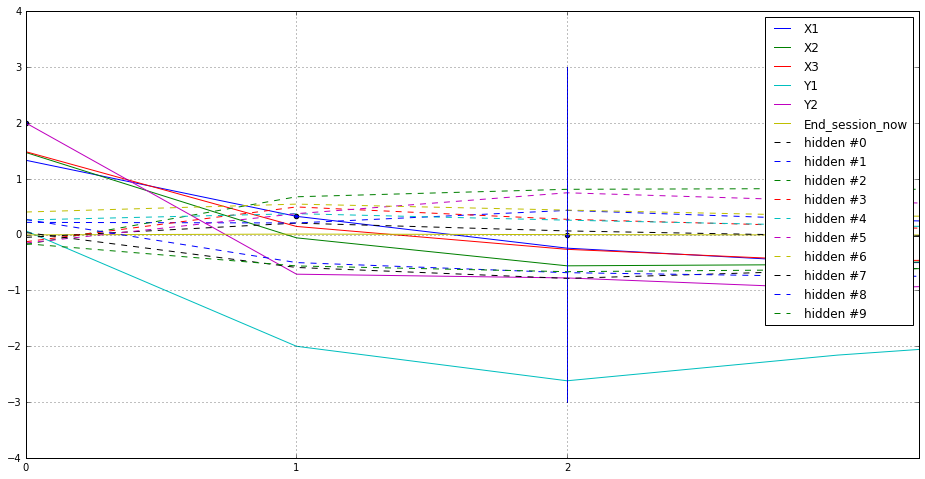

session # 9
 Y2(qv = 1.99966430664) -> -3.0 |  X2(qv = 0.985396385193) -> 1.0 |  End_session_now(qv = -0.000193806830794) -> 0.0 | 



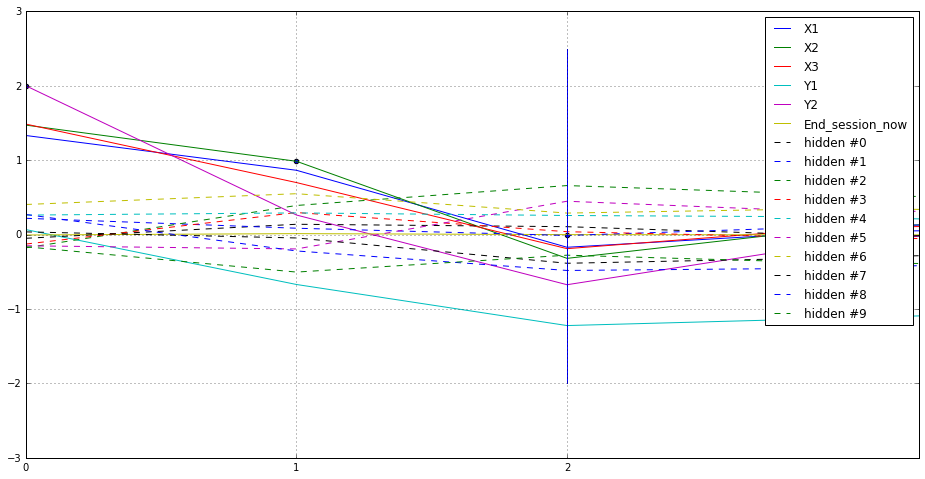

In [22]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
